This is a simple example showing how to use this package to train a machine learning force field using your data.

In this example, we will study a system of two helium atoms interacting through a Lennard-Jones potential. The example is divided into two main sections:

1) Model Setup and Training:
    We will load a pre-generated dataset containing configurations of two helium atoms in a simulation box and use the SymmLearn functions to build and train our neural network model.

2) Results and Comparison:
    Then, we will analyze the results. For this simple case, it is possible to visualize the trained force field and compare it to the reference Lennard-Jones potential.


In [23]:
#using Symmlearn
using Plots
using Random

include("../src/Data_prep.jl")
include("../src/Utils.jl")
include("../src/Train.jl")
include("../src/Model.jl")


predict_forces (generic function with 1 method)

The loading process of the .xyz dataset con be done as illustrated here in the next code block.

Everything is fuly explained in the documentation, it's important to mention that the target data is stored in a Vector of Sample structs, containing both the sample energy and the forces

This dataset consists in 1000 samples, for each the energy was computed using a Lennard-Jones potential with $\sigma$ = 1 and $\epsilon$ = 1.

For each sample the distance between the two Helium atoms was randomly generated between 0.95 $\sigma$ and 2.5 $\sigma$, one atom is in the origin the other is on the x axis




In [24]:
file_path = "helium_LJ_dataset.xyz"

x_train, y_train, x_val, y_val, x_test, y_test, mean_and_std, unique_species, species_idx, _= 
    xyz_to_nn_input(file_path)

e_mean = mean_and_std[1]
e_std = mean_and_std[2]



println("Data has been extracted")

Data has been extracted


The xyz_to_nn_input function returns the data already split in test, train and validation, the mean and the standard deviation of the energies  to renormalize them later and the lattice parameters, used by the model to compute the atomic distances with periodic boundary conditions ( in this example we won't be using PBC as the helium atoms are confined in a box )

In the next block we will build the model and check how to compute all the useful objects

In [25]:



N_G1 = 5 #define the model using 10 G1 symmetry functions
r_cutoff = 2.75f0

#we set the random seed for reproducibility 

seed = 42
Random.seed!(seed)   

#we use depth = 1, a branch with a small number of parameters, enough for this task
model = build_species_models(unique_species, species_idx, N_G1, r_cutoff , depth = 1 , seed = seed) 

#We can check if the model and the loss work as we expected on a small batch 

x_batch = x_train[1:3, :]
y_batch = y_train[1:3]

#in order to be more efficient the model actually takes as an input the distances not the coordinates
batch_dist = distance_matrix_layer(x_batch)

println("Model output with a batch as input: ", dispatch(batch_dist , model))

#in order to compute the forces we multiply the constant part of the derivative
#with the part that depends on the model parameters, the first one is computed by 
#the function distance_derivatives, the second part is directly computed in the force_loss
#later we'll show how to compute and obtain the forces predicted by the model, right now we only care about the loss

const_derivatives = distance_derivatives(x_batch)

e = extract_energies(y_batch)
f = extract_forces(y_batch)

#we can now compute the force loss 

fconst = force_loss(model, batch_dist, f, const_derivatives)

println("Model force loss with a batch as an input: ", fconst)
println("Model total loss with batch input: ", loss(model, batch_dist, e , fconst))




Model output with a batch as input: Float32[3.3992665, -1.7232511, 0.54203415]
Model force loss with a batch as an input: Float32[0.22858548, 1.246765, 37.611797]
Model total loss with batch input: 17.034319


Now we can train the model

In [26]:

#we use both forces and energies to train the model  
 

last_model, best_model, train_loss, val_loss = train_model!(
        model,
        x_train, y_train,
        x_val, y_val;
         forces = true,  epochs = 500 , initial_lr = 1e-3 )


println("Training has been completed!")

Progress: 100%|█████████████████████████████████████████| Time: 0:03:18


Training has been completed!


Our model has been trained, we can look at the results

This first plot compares the energy of each pair as a function of the distance between the two atoms with the LJ potential for the test set

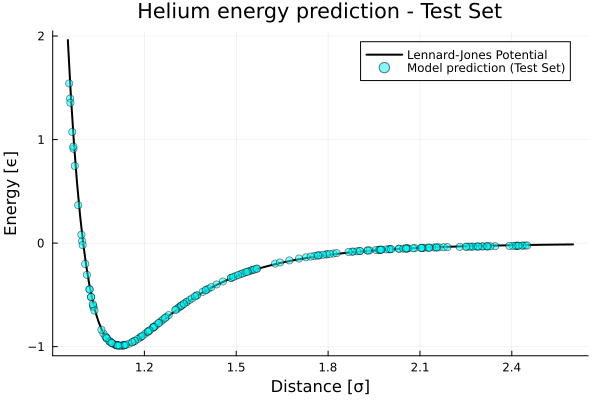

In [27]:
#extract the test energies
test_dist = distance_matrix_layer(x_test)


# Denormalize model predictions for the test set using Z-score inversion
test_guess = dispatch(test_dist, best_model) .* e_std .+ e_mean
# Extract interatomic distances from the test set (for plotting)
r_ij = [only(test_dist[i, 1].dist) for i in 1:size(x_test, 1)]

#We can also make the data for the reference plot

f_lj(x) = 4*(1/x^(12) - 1/x^(6))

x = 0.95:0.01:2.6
y = f_lj.(x)


plot(x, y,
    label="Lennard-Jones Potential",
    color="black",
    lw=2
)

# Plot predictions vs Lennard-Jones potential
scatter!(r_ij, test_guess,
    label="Model prediction (Test Set)",
    alpha=0.5,
    color="cyan"
)



xlabel!("Distance [σ]")
ylabel!("Energy [ϵ]")
title!("Helium energy prediction - Test Set")


As expected the model managed to reproduce very well the Lennard Jones potential

It's possible to do an analogous analysis to see how well the model predicts the forces


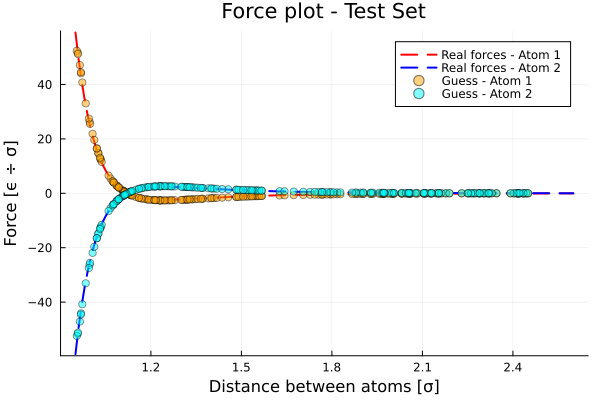

In [28]:
# first we compute the forces using the model

f_guess = predict_forces(x_test, best_model)

#then we extract the x axis forces applied to atom 1 and to atom 2
#f_guess in an object with dimensions ( batch , atom , [F_x , F_y , F_z])

f_guess_1 = f_guess[ : , 1 , 1] #we only care about the forces on the x axis

f_guess_2 = f_guess[ : , 2 , 1]

#this is the analytical formula for the forces applied to atom 1
#the forces on atom 2 will just be -F(x)

F(x) = 24 * (2/x^13 - 1/x^7)

x = 0.95:0.01:2.6
y_1 = F.(x)
y_2 = - F.(x)



# ---- Plot ----

# Model predictions
plot(x, y_1,
    label="Real forces - Atom 1 ",
    color="red",
    linestyle =:dash,
    lw = 2
)

plot!(x, y_2,
    label="Real forces - Atom 2 ",
    color="blue",
    linestyle =:dash,
    lw = 2
)

  scatter!(r_ij , f_guess_1,
    label="Guess - Atom 1",
    color="orange",
    alpha = 0.5
)

  scatter!(r_ij , f_guess_2,
    label="Guess - Atom 2",
    color="cyan",
    alpha = 0.5
)


# Labels
ylabel!("Force [ϵ ÷ σ]")
xlabel!("Distance between atoms [σ]")
title!("Force plot - Test Set")
ylims!(minimum(y_2)*1.01 , maximum(y_1)*1.01)



Also the forces are well reproduced by the model

A more quantitative analysis can be done by computing the rmse per atom for both the forces and the energies, that's what we will do in this next and last block


Energy RMSE/atom = 0.014 ϵ


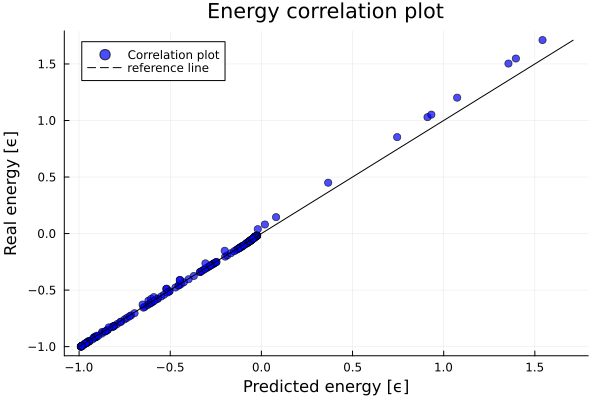

Force RMSE per atom = 0.0881 ϵ/σ


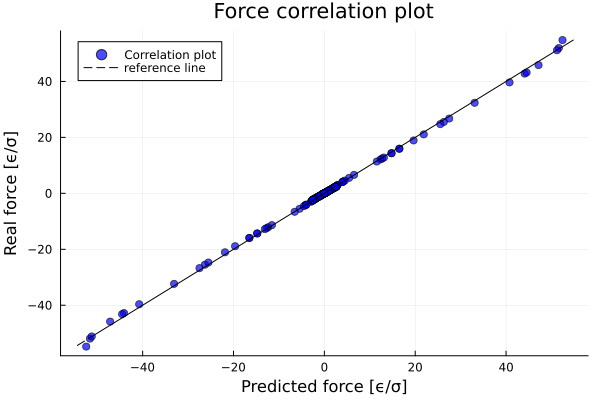

In [29]:


# ---- Energies ----
e_test = extract_energies(y_test) .* e_std .+ e_mean
n_atoms = 2
rmse_total_e = sqrt(mean((test_guess .- e_test).^2))
rmse_per_atom = rmse_total_e / n_atoms


println("Energy RMSE/atom = $(round(rmse_per_atom  , digits = 3)) ϵ")

p1 = scatter(test_guess , e_test,
    label="Correlation plot",
    color="blue",
    alpha = 0.7,
    xlabel = "Predicted energy [ϵ]",
    ylabel = "Real energy [ϵ]",
    title = "Energy correlation plot"
)
plot!(p1, e_test, e_test,
    label="reference line",
    color="black",
    style=:dash
)

display(p1)

# ---- Forces ----
#the flat = true option is useful only when making plots like this one
#looking at the data in this form is not suggested

f_test = extract_forces(y_test , flat = true)
f_guess = predict_forces(x_test, best_model , flat = true)
rmse_f = sqrt(mean((f_guess .- f_test).^2)) / n_atoms
println("Force RMSE per atom = $(round(rmse_f, digits=4)) ϵ/σ")

p2 = scatter(f_guess , f_test,
    label="Correlation plot",
    color="blue",
    alpha = 0.7,
    xlabel = "Predicted force [ϵ/σ]",
    ylabel = "Real force [ϵ/σ]",
    title = "Force correlation plot"
)
plot!(p2, f_test, f_test,
    label="reference line",
    color="black",
    style=:dash
)

display(p2)
